# Descrição do Trabalho
O arquivo trabalho.zip possui imagens de leucócitos na parte central. As imagens são nomeadas como "ImXXX_Y_Z.jpg". Onde ImXXX é o número da imagem, Y é o seu número da sequência de alteração (data augmentation) e Z a sua classe (0 ou 1). Onde, 0 indica paciente normal e 1 pacientes com leucemia.

Utilizando técnicas de Visão Computacional e/ou CNNS extraia características das imagens e faça a sua correta classificação (0 ou 1). Lembre-se de separar os grupos de treinamento e teste. Você pode utilizar a técnica de k-folds para a divisão das imagens e evitar o overfitting.

Entregue um arquivo zip com um relatório do seu trabalho, o(s) código(s) fonte(s) e um README indicando como o seu trabalho funciona. Você pode fazer no Colab e disponibilizar o arquivo fonte.

In [1]:
from IPython.display import Image 
import numpy as np

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

import keras
import os

In [2]:
import tensorflow as tf
print("Versão do TensorFlow:", tf.__version__)

import keras as K
print("Versão do Keras:", K.__version__)

Versão do TensorFlow: 2.4.0
Versão do Keras: 2.4.3


#### Executar o comando abaixo somente se estiver rodando no Colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
print('a')

In [5]:
#images_root_path = '/content/drive/MyDrive/IAP/VISAO COMPUTACIONAL/output/'
images_root_path = '/data/'
train_path = images_root_path + 'train'
test_path = images_root_path + 'test'
validation_path = images_root_path + 'val'

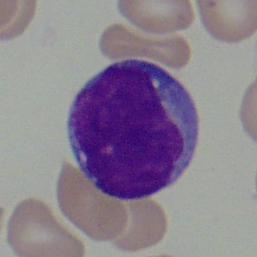

In [6]:
Image(filename=f'{train_path}/class_b/Im001_0_1.jpg')

## Pré-Processamento

In [7]:
# Train dataset
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

training_set = train_datagen.flow_from_directory(
    train_path,
    seed=42,
    target_size = (128, 128),
    batch_size = BATCH_SIZE,
    class_mode = 'binary')

# Validation dataset
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory(
    validation_path,
    seed=42,
    target_size = (128, 128),
    batch_size = BATCH_SIZE,
    class_mode = 'binary')

Found 3820 images belonging to 2 classes.
Found 546 images belonging to 2 classes.


## Modelo

* métrica escolida foi RECALL para evitar o **FALSO NEGATIVO** 

In [14]:
tf.keras.backend.clear_session()

# Inicializando a Rede Neural Convolucional
classifier = Sequential()

# Camada de Convolução
classifier.add(Conv2D(64, (3, 3), input_shape = (128, 128, 3), kernel_initializer = 'he_uniform', activation = 'relu', padding ="same"))
classifier.add(MaxPooling2D((2, 2)))

#  Flattening
classifier.add(Flatten())

# Full connection
classifier.add(Dense(units = 32, activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compilando a rede
classifier.compile(
    optimizer = 'rmsprop', 
    loss = 'binary_crossentropy', 
    metrics = [
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy')])

In [15]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                8388640   
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 8,390,465
Trainable params: 8,390,465
Non-trainable params: 0
______________________________________________

## Treinamento

In [16]:
# Executando o treinamento (esse processo pode levar bastante tempo, dependendo do seu computador)
history = classifier.fit(
    training_set,
    steps_per_epoch = 100,
    epochs = 5,
    validation_data = validation_set,
    validation_steps = 10)

classifier.save('model')

Epoch 1/5
  1/100 [..............................] - ETA: 12:57 - loss: 0.8507 - fn: 18.0000 - accuracy: 0.3438

KeyboardInterrupt: ignored

In [ ]:
# Zip saved model
# !zip -r ./model.zip ./model/

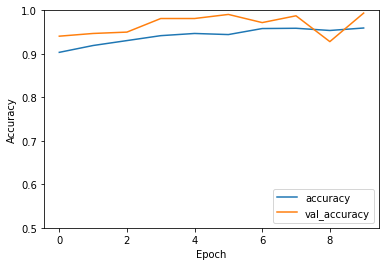

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Previsões

In [ ]:
# LOAD MODEL FROM GDRIVE
#classifier = tf.keras.models.load_model('/content/drive/MyDrive/IAP/VISAO COMPUTACIONAL/model')
#classifier.summary()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

testing_set = test_datagen.flow_from_directory(
    test_path,
    seed=42,
    target_size = (128, 128),
    batch_size = 1,
    classes = ['classe_0', 'classe_1'],
    class_mode = 'binary')

num_of_samples = len(testing_set.filenames)

Found 1094 images belonging to 2 classes.


In [ ]:
classifier.evaluate(testing_set, batch_size=128)

1094/1094 [==============================] - 5s 5ms/step - loss: 0.0509 - fn: 8.0000 - accuracy: 0.9753


[0.05094330385327339, 8.0, 0.9753199219703674]

In [ ]:
# Predicoes na base de teste
#predicted = classifier.predict(testing_set)
predicted = (classifier.predict(testing_set) > 0.5).astype("int32")
predicted = [pred[0] for pred in predicted]
#predicted=np.argmax(predicted,axis=1)

In [ ]:
confusion_matrix(testing_set.classes, predicted)

array([[262, 285],
       [274, 273]])

In [ ]:
accuracy_score(testing_set.classes, predicted)

0.4890310786106033

In [ ]:
fpr, tpr, _ = roc_curve(testing_set.classes, predicted)
roc_auc = auc(fpr, tpr)
print(roc_auc) # 0.48687706586366053

0.4908592321755027


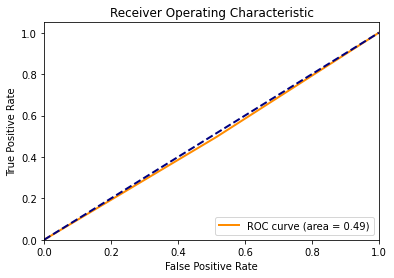

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()